<a href="https://colab.research.google.com/github/Fillipe16/CV_ChestXR/blob/main/CV_LungSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Instalando dependencias faltantes
!pip install segmentation_models_pytorch
!pip install pytorch_lightning

In [2]:
# Blibiotecas para manipulação de dados
import numpy as np
from imutils import paths
import torch
import re
from shutil import make_archive
# Bibliotecas de visualização
import matplotlib.pyplot as plt
import PIL
import cv2
# Bibliotecas para seleção
from sklearn.model_selection import train_test_split
# Bibliotecas de modelos
import segmentation_models_pytorch as sm
import pytorch_lightning as pl

from torchmetrics import Dice
from torchvision import transforms


# 1-) Leitura e Preprocessamento dos dados

In [3]:
# Extraindo apenas os paths das imagens -- Montgomery Dataset
path_montgomery = "/content/drive/MyDrive/CV_COVID19/Data/MontgomerySet"
folders = ['/CXR_png','/ManualMask/leftMask','/ManualMask/rightMask']

imgs_paths_01 = sorted(list(paths.list_images(path_montgomery+folders[0])))
left_masks_paths_01 = sorted(list(paths.list_images(path_montgomery+folders[1])))
right_masks_paths_01 = sorted(list(paths.list_images(path_montgomery+folders[2])))

masks_paths_01 = [left+" "+right for left,right in zip(left_masks_paths_01,right_masks_paths_01)]


In [4]:
# Extraindo apenas os paths das imagens -- Dataset da China
path_montgomery = "/content/drive/MyDrive/CV_COVID19/Data/ChinaSet_AllFiles"
folders = ['/CXR_png','/ManualMask']

imgs_paths_02 = sorted(list(paths.list_images(path_montgomery+folders[0])))
masks_paths_02 = sorted(list(paths.list_images(path_montgomery+folders[1])))

# Nem todas as imagens de Raio-X tem mask, necessário filtrar

masks_numbers = [int(re.findall("\d{4}",p)[0]) for p in masks_paths_02] # Extraindo o numero de cada mask
total_numbers = np.arange(1,663,1)
flag_array = np.array([True if n in masks_numbers else False for n in total_numbers]) # Analisando se o numero da imagem e está no total de imagens
imgs_paths_02_new = np.array(imgs_paths_02)[flag_array].tolist() # Filtrando as imagens


### Data Augmentation

In [ ]:
# Criação das funções de aumento de dados(transformações)
# As imagens ja estão com 224px x 224px, a fim de poupar espaço de armazenamento
def rotation(img,width,height,angle):
  image_center = (int(width/2),int(height/2))

  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)

  img = cv2.warpAffine(img, rot_mat, (int(width),int(height)))
  img = cv2.resize(img,(224,224)) 
  return img

def croping(img,width,height,factor=0.6):
  alpha = factor**(1/2)
  x = int((width/2)*(1-alpha))
  y = int((height/2)*(1-alpha))

  img = img[x:-x, y:-y]
  img = cv2.resize(img,(224,224)) 
  return img


In [ ]:
# Criando e salvando as imagens modificadas
da_mask_path = "/content/data_augmented/MASKS/"
da_rximg_path = "/content/data_augmented/RXIMG/"

for i in range(len(imgs_paths_02_new)):
  angle = np.random.randint(low=-45,high=45) # Selecionando, de forma aleatoria, um angulo para rotacionar cada par (raiox,mask)

  # Augmentation nas imagens de Raio-X
  img_path = imgs_paths_02_new[i]
  img = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
  width_01 = img.shape[0]
  height_01 = img.shape[1]

  rx_rotated = rotation(img,width_01,height_01,angle)
  rx_croped = croping(img,width_01,height_01)

  name_mask = mask_path.split('/')[-1]
  cv2.imwrite(da_mask_path+'rotated_'+name_mask, mask_rotated)
  cv2.imwrite(da_mask_path+'croped_'+name_mask, mask_croped)

  # Augmentation nas imagens das masks
  mask_path = masks_paths_02[i]
  mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
  width_02 = mask.shape[0]
  height_02 = mask.shape[1]

  mask_rotated = rotation(mask,width_02,height_02,angle)
  mask_croped = croping(mask,width_02,height_02)

  name_rximg = img_path.split('/')[-1]
  cv2.imwrite(da_rximg_path+'rotated_'+name_rximg, rx_rotated)
  cv2.imwrite(da_rximg_path+'croped_'+name_rximg, rx_croped)

In [ ]:
# Zipando a pasta 
make_archive("data_augmented","zip","/content/data_augmented")

'/content/data_augmented.zip'

### Criando o dataset pytorch

In [5]:
# Extraindo apenas os paths das imagens -- Dataset augmented
path_aug = "/content/drive/MyDrive/CV_COVID19/Data/data_augmented" 
folders = ['/RXIMG','/MASKS']

imgs_paths_03 = sorted(list(paths.list_images(path_aug+folders[0])))
masks_paths_03 = sorted(list(paths.list_images(path_aug+folders[1])))

In [6]:
# Unidos todos os dados extraidos

imgs_paths = imgs_paths_01 + imgs_paths_02_new + imgs_paths_03
masks_paths = masks_paths_01 + masks_paths_02 + masks_paths_03

In [7]:
# Separação em Treino e Validação
seed = 42
X_train,X_val,y_train,y_val = train_test_split(imgs_paths,masks_paths,
                                               train_size=1480,random_state = seed) # dataset de treino precisa ser multiplo do batch_size

print(f'shape X_train: {len(X_train)}')
print(f'shape y_train: {len(y_train)}')
print(f'shape X_val: {len(X_val)}')
print(f'shape y_val: {len(y_val)}')

shape X_train: 1480
shape y_train: 1480
shape X_val: 356
shape y_val: 356


In [8]:
# Definição da classe para criação do dataset pytorch personalidade
# Utilização de transformações: Escala Cinza; Valor do pixel de 0 a 1; Transformção em Tensor; Resize em 224px x 224px
class RXLungDataset(torch.utils.data.Dataset):
    def __init__(self, imgs_paths, masks_paths,clahe,data_transforms=None):
        self.imgs_paths = imgs_paths
        self.masks_paths = masks_paths
        self.transform = data_transforms
        self.clahe = clahe
    def __getitem__(self, index):
        
        imgpath = self.imgs_paths[index]

        rx_image = cv2.imread(imgpath,cv2.IMREAD_GRAYSCALE)
        rx_image = clahe.apply(rx_image)/255
        if self.transform:
          rx_image = self.transform(rx_image)

        if(self.masks_paths):
          unpack = self.masks_paths[index].split()
          if(len(unpack)==2): # Máscaras do dataset do Montgomery apresentam os pulmões( direito e esquerdo ) em arquivos separadas
            leftmask_path,rightmask_path = unpack
    
            left_mask = cv2.imread(leftmask_path,cv2.IMREAD_GRAYSCALE)/255
            right_mask = cv2.imread(rightmask_path,cv2.IMREAD_GRAYSCALE)/255
            mask = left_mask+right_mask # União das máscaras dos pulmoes em uma só imagem
          else:
            mask = cv2.imread(self.masks_paths[index],cv2.IMREAD_GRAYSCALE)/255

          if self.transform:
            mask = self.transform(mask)

          sample = (rx_image, mask)
          return sample
        else:
          return rx_image

    def __len__(self):
        return len(self.imgs_paths)

width = height = 224
data_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Resize((width,height)),
                                    ])
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))


In [9]:
# Criação dos dataset de treino e validação
train_dataset = RXLungDataset(X_train,y_train,clahe,data_transforms)
val_dataset = RXLungDataset(X_val,y_val,clahe,data_transforms)

batch_size = 8
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False)

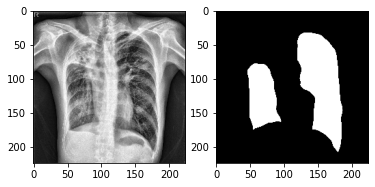

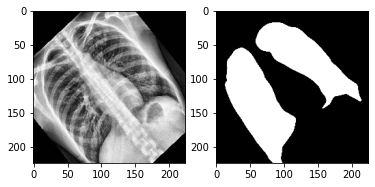

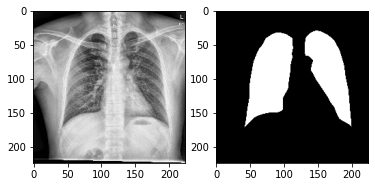

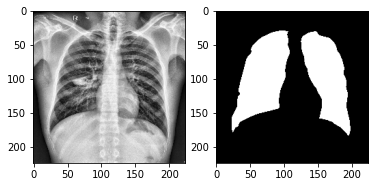

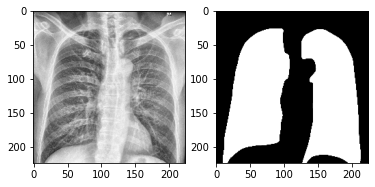

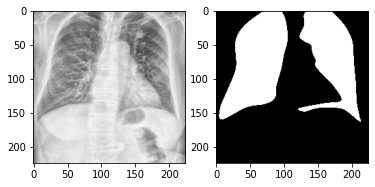

In [ ]:
# Visualização de alguns pares (x,y)
for step, (x, y) in enumerate(train_dataset):
  plt.subplot(1, 2, 1)
  plt.imshow(x.detach().numpy().reshape((width,height)),cmap='gray')
  plt.subplot(1, 2, 2)
  plt.imshow(y.detach().numpy().reshape((width,height)),cmap='gray')
  plt.show()
  if(step==5):
    break

# 2-) Modelo

In [10]:
# Criação da classe para o modelo personalizado utilizando o framework Lightning torch
class LungModel(pl.LightningModule):
    def __init__(self,arch, encoder_name, in_channels, out_classes,batch_size):
        super().__init__()
        # Importação do modelo com encode ja pretreinado
        self.model = sm.create_model(
            arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes)
        
        self.in_channels = in_channels
        self.batch_size = batch_size
        self.loss_fn = sm.losses.DiceLoss(sm.losses.BINARY_MODE, from_logits=True)

    def forward(self, image):
        return self.model(image)

    def shared_step(self, batch, stage):
        image,mask = batch

        image = image.unsqueeze(0) 
        mask = mask.unsqueeze(0)

        image = torch.reshape(image,[self.batch_size, self.in_channels, 224, 224])
        mask = torch.reshape(mask,[self.batch_size, self.in_channels, 224, 224])

        y_hat = self.forward(image)

        loss = self.loss_fn(y_hat, mask)

        # Utilização da função sigmoid para os valores ficar entre 0 e 1
        prob_mask = y_hat.sigmoid() 
        # Toda predição abaixo de 0.5(50%) é dada como fora dos pulmões, o contrario ocorre para aquelas acima de 0.5
        pred_mask = (prob_mask > 0.5) 

        tp, fp, fn, tn = sm.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")

        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }
    def shared_epoch_end(self, outputs, stage):
        # Criação de métrica de avaliação
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

     
        per_image_iou = sm.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        
        dataset_iou = sm.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }
        
        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train") 

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")

    def validation_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "train")

    def validation_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "valid")

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        return self(batch)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)

In [ ]:
# Instaciamento do modelo, definindo arquitetura e backbone
model = LungModel("Unet","resnet34",1,1,batch_size)
model = model.double()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
# Criação do objeto de treino
trainer = pl.Trainer(
    gpus=1,
    max_epochs=7
)

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:467: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
# Finetuning o modelo
trainer.fit(
    model, 
    train_dataloaders=train_dataloader,
)

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type     | Params
-------------------------------------
0 | model   | Unet     | 24.4 M
1 | loss_fn | DiceLoss | 0     
-------------------------------------
24.4 M    Trainable params
0         Non-trainable params
24.4 M    Total params
97.720    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=7` reached.


In [11]:
model_path = "/content/drive/MyDrive/CV_COVID19" + "/UnetResNet_lungSegmentation_2"

In [ ]:
torch.save(model.state_dict(), model_path)

# 3-) Avaliação

In [ ]:
# Importação do modelo finetuned
model = LungModel("Unet","resnet34",1,1,1)
model.load_state_dict(torch.load(model_path))
model.double()

In [13]:
trainer = pl.Trainer(
    max_epochs=5
)

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
# Avaliação do modelo
valid_metrics = trainer.validate(model, dataloaders=val_dataloader, verbose=False)
print(valid_metrics)

Validation: 0it [00:00, ?it/s]

[{'valid_per_image_iou': 0.9241632223129272, 'valid_dataset_iou': 0.9238921999931335}]


# 4-) Predição

In [18]:
# Definição dos diretorios onde estão os dados
test_train_path = "/content/drive/MyDrive/CV_COVID19/Data/Coronahack-Chest-XRay-Dataset/train"
test_train_paths = sorted(list(paths.list_images(test_train_path)))

test_test_path = "/content/drive/MyDrive/CV_COVID19/Data/Coronahack-Chest-XRay-Dataset/test"
test_test_paths = sorted(list(paths.list_images(test_test_path)))

In [19]:
# Criação dos datasets e dataloaders 
test_train_dataset = RXLungDataset(test_train_paths,None,clahe,data_transforms)
test_train_dataloader = torch.utils.data.DataLoader(test_train_dataset, batch_size=1, shuffle=False)

test_test_dataset = RXLungDataset(test_test_paths,None,clahe,data_transforms)
test_test_dataloader = torch.utils.data.DataLoader(test_test_dataset, batch_size=1, shuffle=False)

In [25]:
# Segmentação das imagens que irão para classificação
lungs_test_path = "/content/lungs/"

def make_predictions(dataloader,paths,f):
  for step,x in enumerate(dataloader):

    mask = model(x).sigmoid()
    
    mask = mask.detach().numpy().reshape((224,224))
    image = x.detach().numpy().reshape((224,224))

    mask[mask>=0.5] = 1
    mask[mask<0.5] = 0
    image[mask==0] = 0

    lung = PIL.Image.fromarray(image*255)
    lung = lung.convert('RGB')
    name = paths[step].split('/')[-1]
    lung.save(lungs_test_path+f+name)
      
make_predictions(test_train_dataloader,test_train_paths,'train/') 
make_predictions(test_test_dataloader,test_test_paths,'test/')

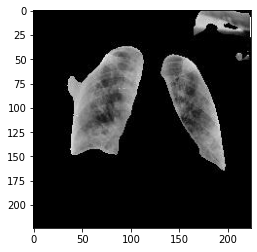

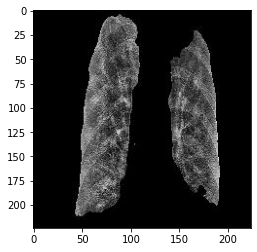

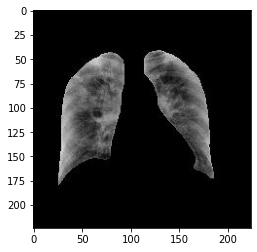

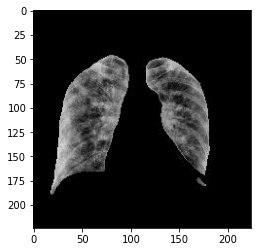

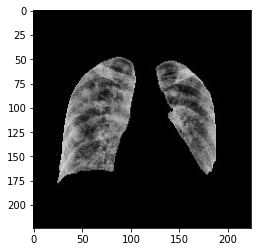

In [29]:
some_test_imags = lungs_test_path+'train/'
for lung_path in sorted(list(paths.list_images(some_test_imags)))[:5]:
  lung = cv2.imread(lung_path)
  plt.imshow(lung)
  plt.show()

In [26]:
# Zipando a pasta 
make_archive("lungs_classification","zip","/content/lungs")

'/content/data_classification.zip'